# Task 3 Predictive Modeling Linear Regresion

# Import Librairies

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import make_pipeline
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy import stats

# Load and Analysis Data

In [5]:
df = pd.read_csv("C:/Users/Lenovo/Desktop/Desktop/CodeAlpha/car data.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [7]:
df['Car_Name'].nunique()

98

In [8]:
df.drop('Car_Name', axis=1, inplace=True)

In [9]:
df.insert(0, "Age", df["Year"].max()+1-df["Year"])
df.drop('Year', axis=1, inplace=True)
df.head()

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,5,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,6,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,8,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,5,4.60,6.87,42450,Diesel,Dealer,Manual,0


# Find the Outliers

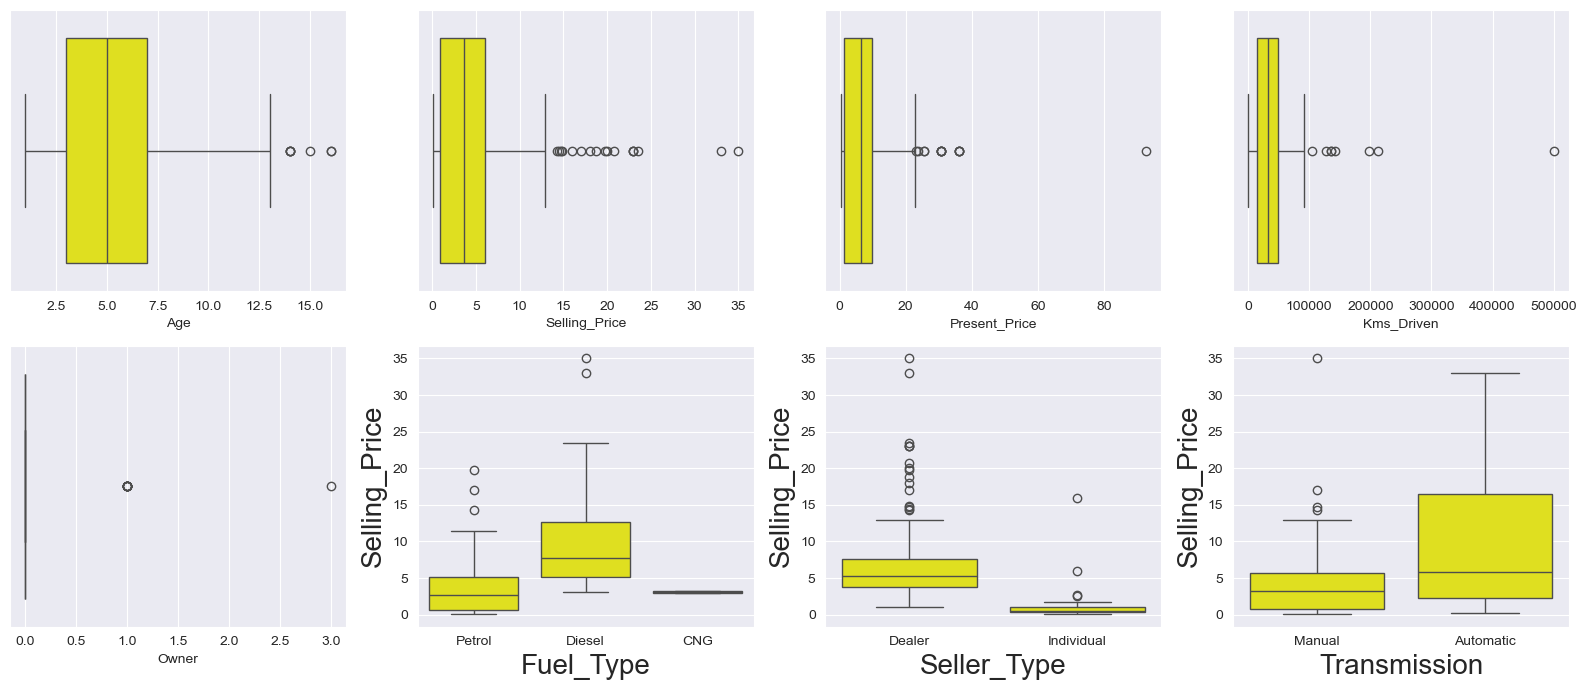

In [11]:
sns.set_style('darkgrid')
colors = ['yellow', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))

orderedCols = np.concatenate([df.select_dtypes(exclude='object').columns.values,
                              df.select_dtypes(include='object').columns.values])

fig, ax = plt.subplots(2, 4, figsize=(16, 7), dpi=100)

for i, col in enumerate(orderedCols):
    x = i // 4
    y = i % 4
    if i < 5:
        sns.boxplot(data=df, x=col, ax=ax[x, y])
        ax[x, y].yaxis.label.set_size(40)
    else:
        sns.boxplot(data=df, x=col, y='Selling_Price', ax=ax[x, y])
        ax[x, y].xaxis.label.set_size(20)
        ax[x, y].yaxis.label.set_size(20)

plt.tight_layout()
plt.show()

In [12]:
outliers_indexes = []
target = 'Selling_Price'

for col in df.select_dtypes(include='object').columns:
    for cat in df[col].unique():
        df1 = df[df[col] == cat]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = q3 - q1
        maximum = q3 + (1.5 * iqr)
        minimum = q1 - (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outliers_indexes.extend(outlier_samples.index.tolist())

for col in df.select_dtypes(include='object').columns:
    for cat in df[col].unique():
        df1 = df[df[col] == cat]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = q3 - q1
        maximum = q3 + (1.5 * iqr)
        minimum = q1 - (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outliers_indexes.extend(outlier_samples.index.tolist())

outliers_indexes = list(set(outliers_indexes))
print('{} outliers were identified, whose indices are:\n\n{}'.format(len(outliers_indexes), outliers_indexes))

20 outliers were identified, whose indices are:

[27, 50, 51, 52, 53, 54, 59, 62, 63, 64, 66, 69, 79, 80, 82, 85, 86, 93, 96, 97]


# The best Outliers

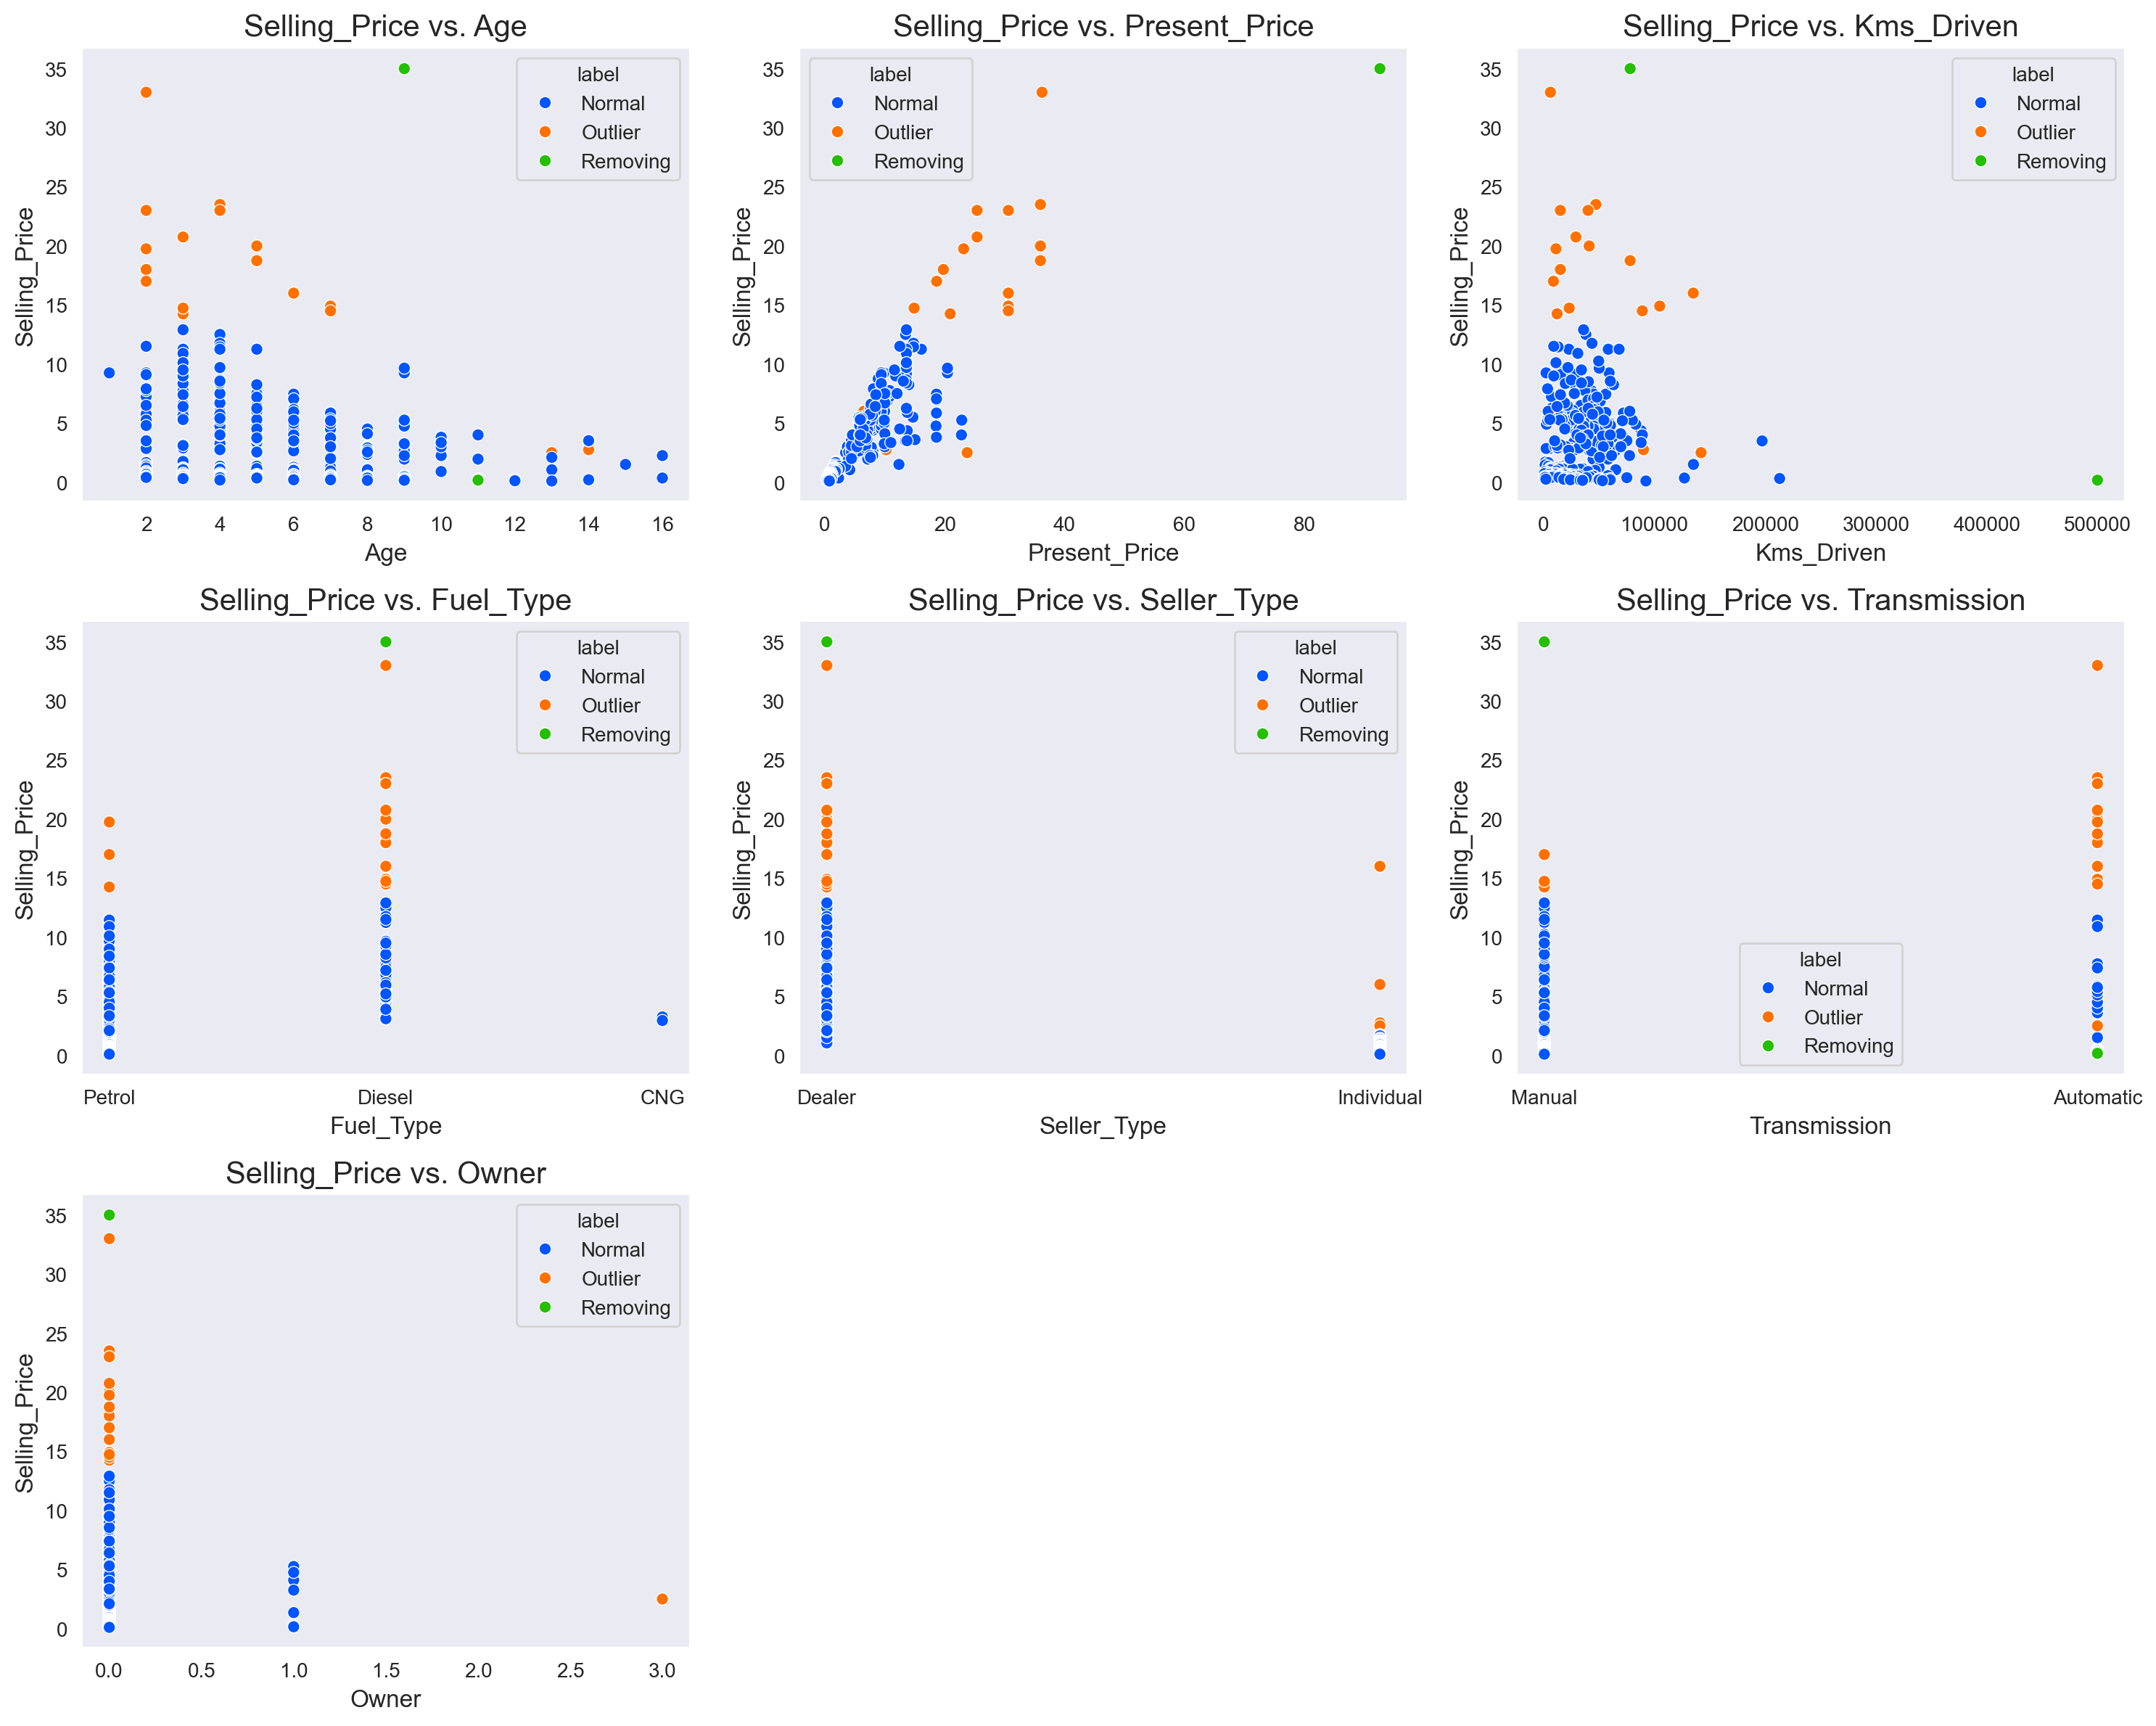

In [14]:
# Labeling Outliers
df1 = df.copy()
df1['label'] = 'Normal'
df1.loc[outliers_indexes, 'label'] = 'Outlier'

# Removing Outliers
removing_indexes = []
removing_indexes.extend(df1[df1[target] > 33].index)
removing_indexes.extend(df1[df1['Kms_Driven'] > 400000].index)
df1.loc[removing_indexes, 'label'] = 'Removing'

# Plot
target = 'Selling_Price'
features = df.columns.drop(target)
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), dpi=200)

for i in range(len(features)):
    x = i // 3
    y = i % 3
    sns.scatterplot(data=df1, x=features[i], y=target, hue='label', ax=ax[x, y])
    ax[x, y].set_title('{} vs. {}'.format(target, features[i]), size=15)
    ax[x, y].set_xlabel(features[i], size=12)
    ax[x, y].set_ylabel(target, size=12)
    ax[x, y].grid()

# Hide the last two unused subplots
ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.tight_layout()
plt.show()

In [15]:
removing_indexes = list(set(removing_indexes))
removing_indexes

[196, 86]

In [16]:
df.isnull().sum()

Age              0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [17]:
df[df.duplicated(keep=False)]

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
15,3,7.75,10.79,43000,Diesel,Dealer,Manual,0
17,3,7.75,10.79,43000,Diesel,Dealer,Manual,0
51,4,23.00,30.61,40000,Diesel,Dealer,Automatic,0
93,4,23.00,30.61,40000,Diesel,Dealer,Automatic,0


In [18]:
df1 = df.copy()
df1.drop(removing_indexes, inplace=True)
df1.reset_index(drop=True, inplace=True)

In [19]:
NumCols = ['Age', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner']
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission']

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2336\183893530.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=20)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2336\183893530.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=20)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2336\183893530.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=20)


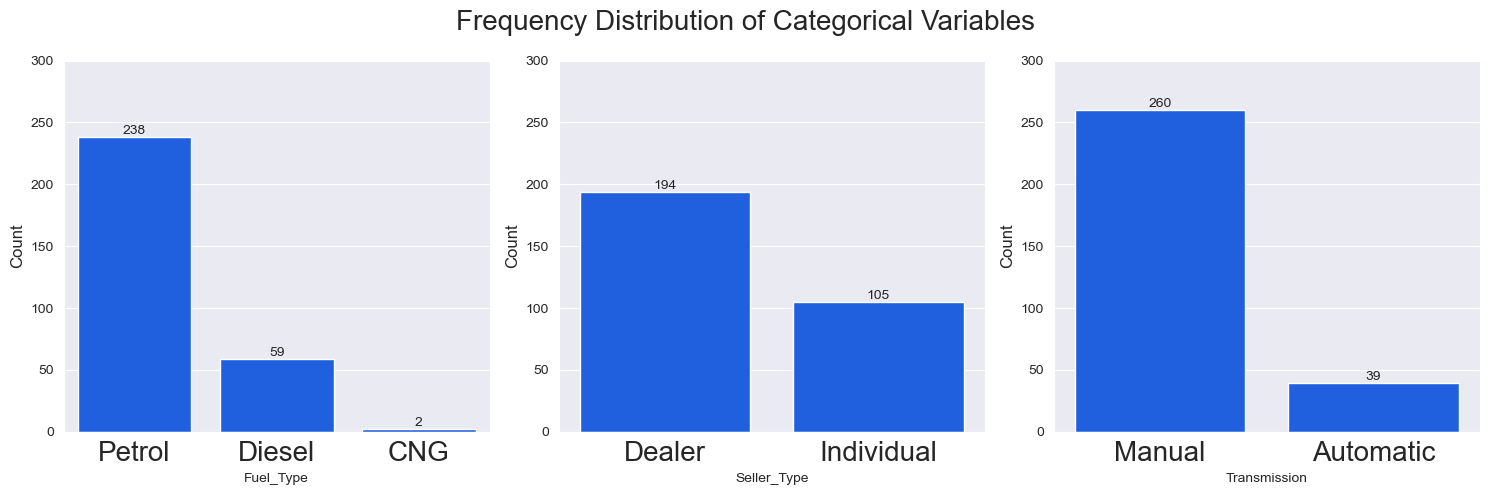

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=100)
colors = ['#0055ff', '#ff7000', '#23bf00']
sns.set_palette(sns.color_palette(colors))

for i in range(len(CatCols)):
    graph = sns.countplot(x=CatCols[i], data=df1, ax=ax[i])
    ax[i].set_xlabel(CatCols[i])
    ax[i].set_ylabel('Count', fontsize=12)
    ax[i].set_ylim([0, 300])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=20)
    for cont in graph.containers:
        graph.bar_label(cont)

plt.suptitle('Frequency Distribution of Categorical Variables', fontsize=20)
plt.tight_layout()
plt.show()

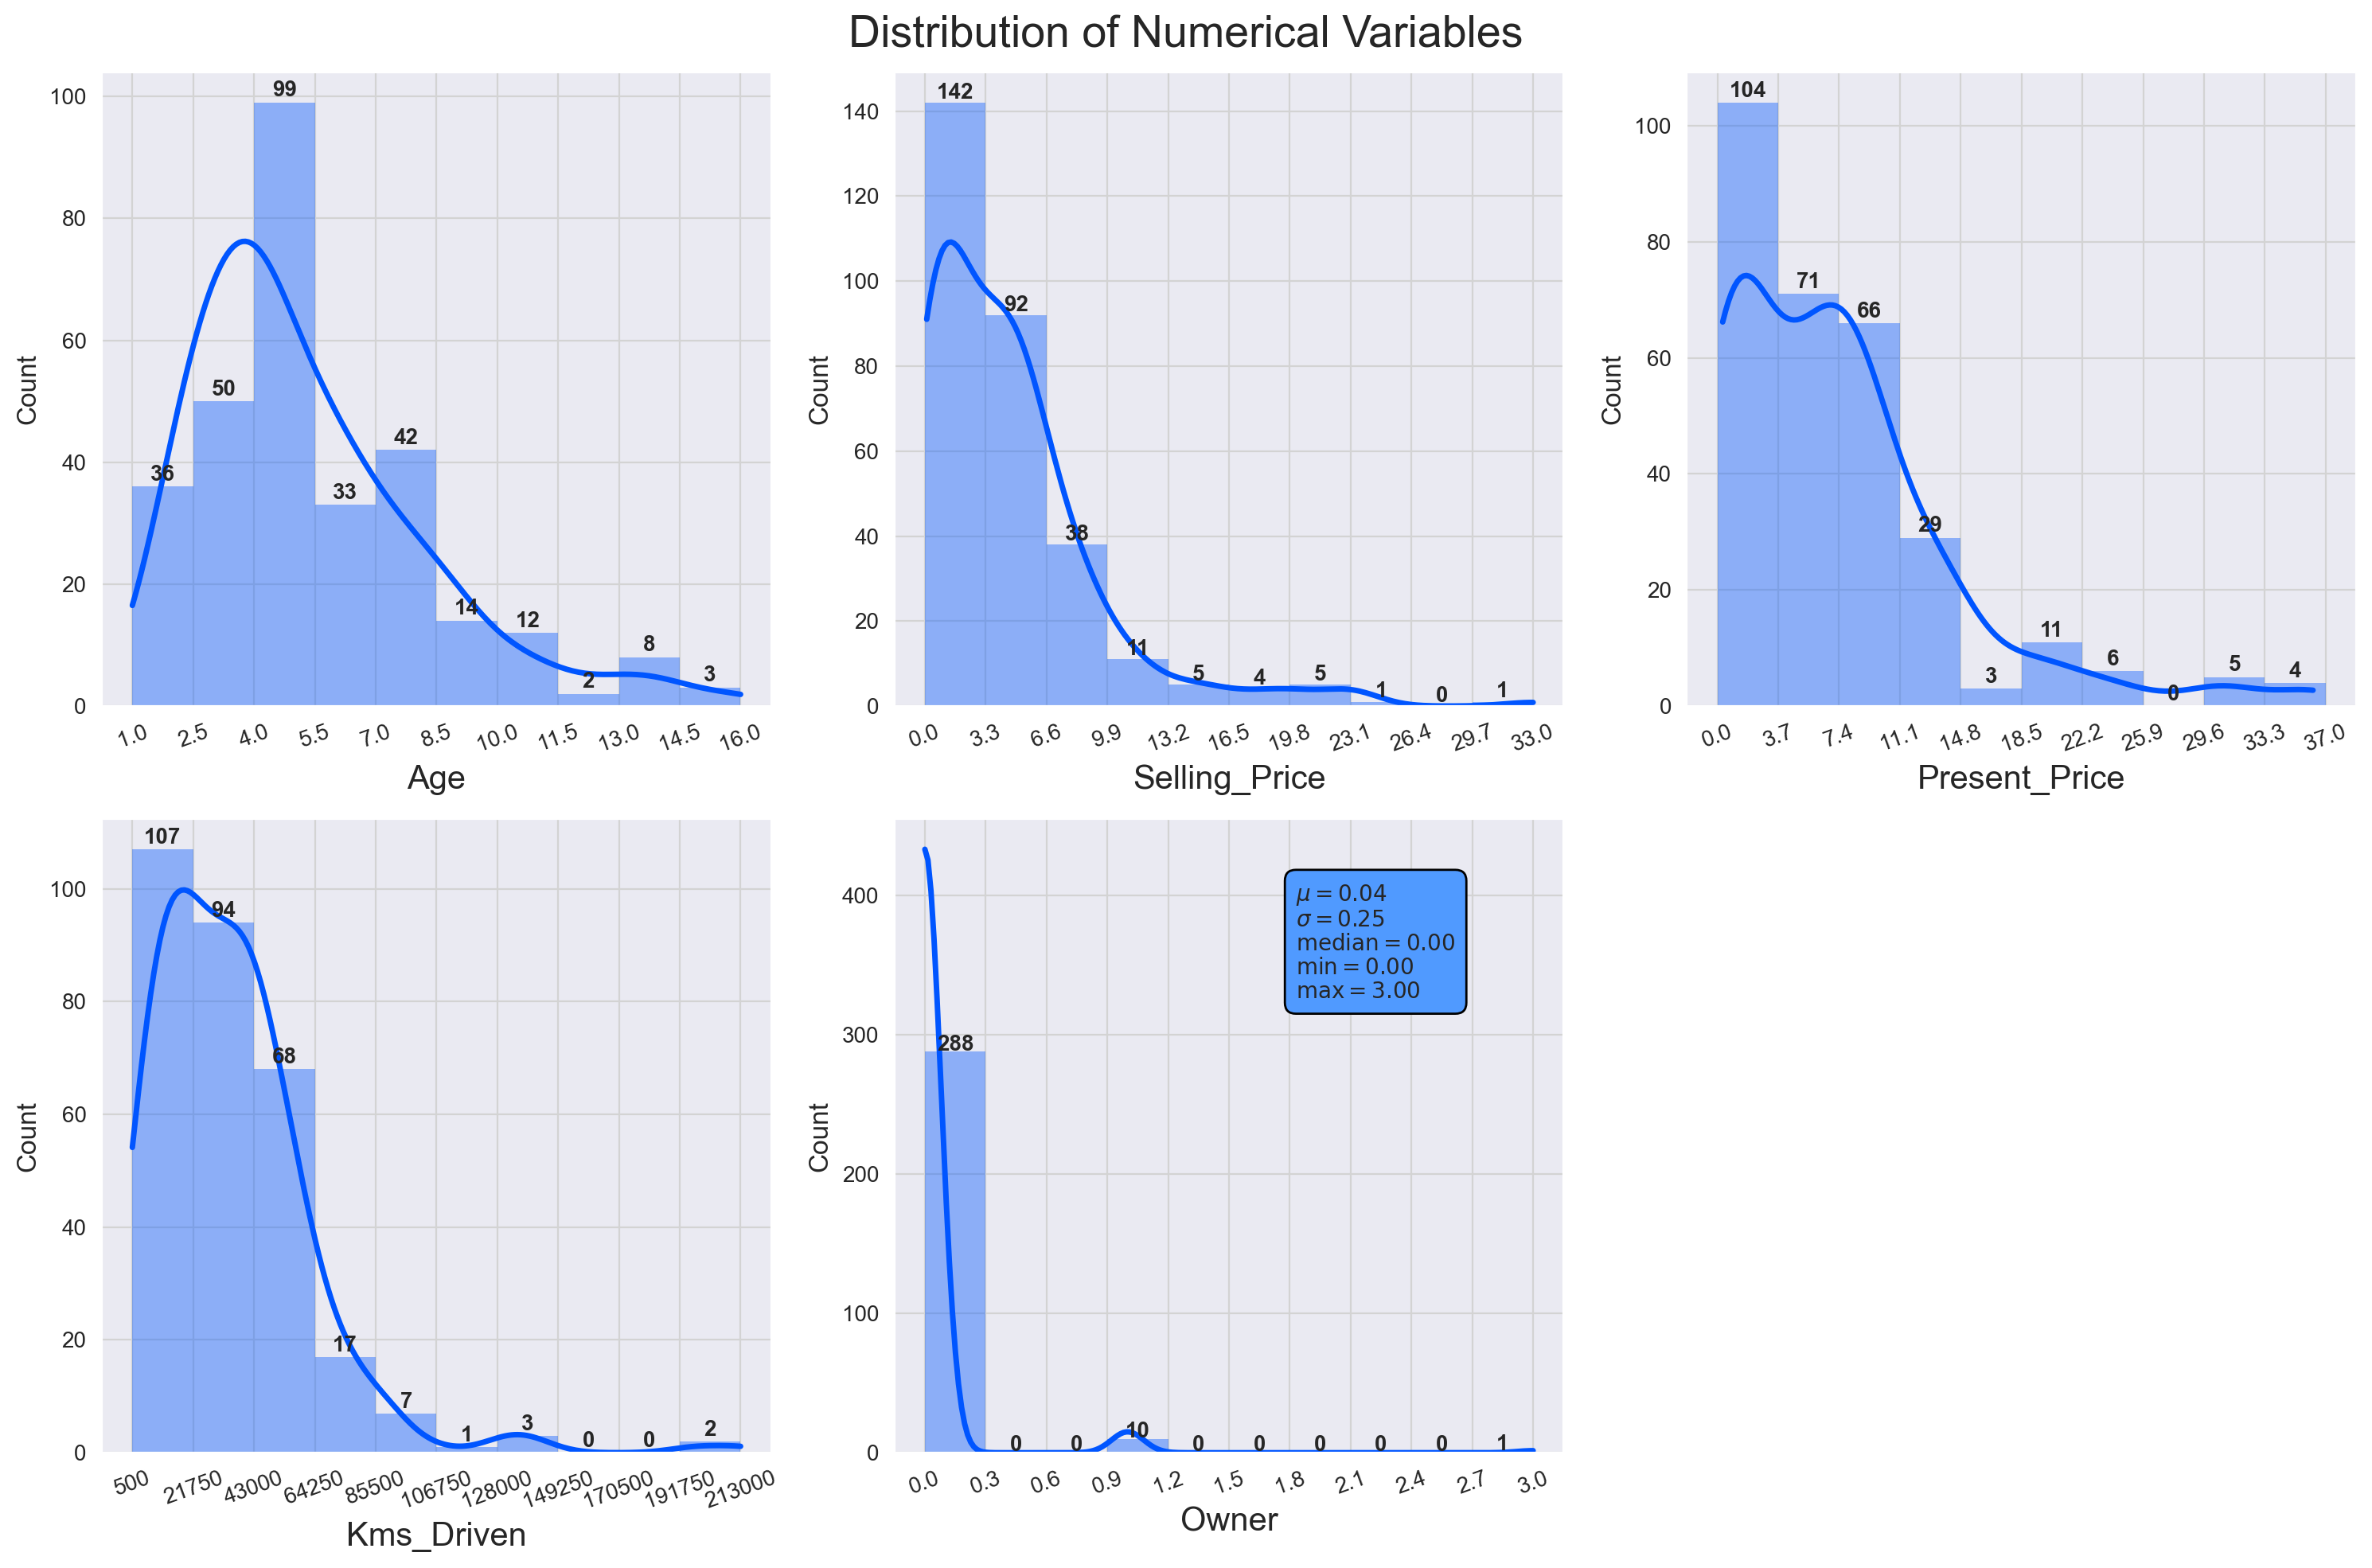

In [21]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (15,10), dpi = 200)
c = '#0055ff'

for i in range(len(NumCols)):
    row = i//3
    col = i%3
    values, bin_edges = np.histogram(df1[NumCols[i]], range=(np.floor(df1[NumCols[i]].min()), np.ceil(df1[NumCols[i]].max())))
    graph = sns.histplot(data = df1, x=NumCols[i], bins = bin_edges, kde = True, ax = ax[row, col], edgecolor = 'none', color = c, alpha = 0.4, line_kws = {'lw': 2.5})
    ax[row,col].set_xlabel(NumCols[i], fontsize = 15)
    ax[row,col].set_ylabel('Count', fontsize=12)
    ax[row,col].set_xticks(np.round(bin_edges, 1))
    ax[row,col].set_xticklabels(ax[row,col].get_xticklabels(), rotation=20)
    ax[row,col].grid(color= 'lightgrey')
    for j,p in enumerate(graph.patches):
        ax[row,col].annotate('{}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+1), ha = 'center', fontsize = 10, fontweight = "bold")

textstr = '\n'.join((
    r'$\mu=%.2f$' %df1[NumCols[i]].mean(),
    r'$\sigma=%.2f$' %df1[NumCols[i]].std(),
    r'$\mathrm{median}=%.2f$' %np.median(df1[NumCols[i]]),
    r'$\mathrm{min}=%.2f$' %df1[NumCols[i]].min(),
    r'$\mathrm{max}=%.2f$' %df1[NumCols[i]].max()
))
ax[row,col].text(0.6, 0.9 , textstr, transform=ax[row,col].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round',facecolor='#509aff', edgecolor='black', pad=0.5))
ax[1,2].axis('off')
plt.suptitle('Distribution of Numerical Variables', fontsize = 20)
plt.tight_layout()
plt.show()

# Selling Price Vs Numerical Features Bivariate Analysis.

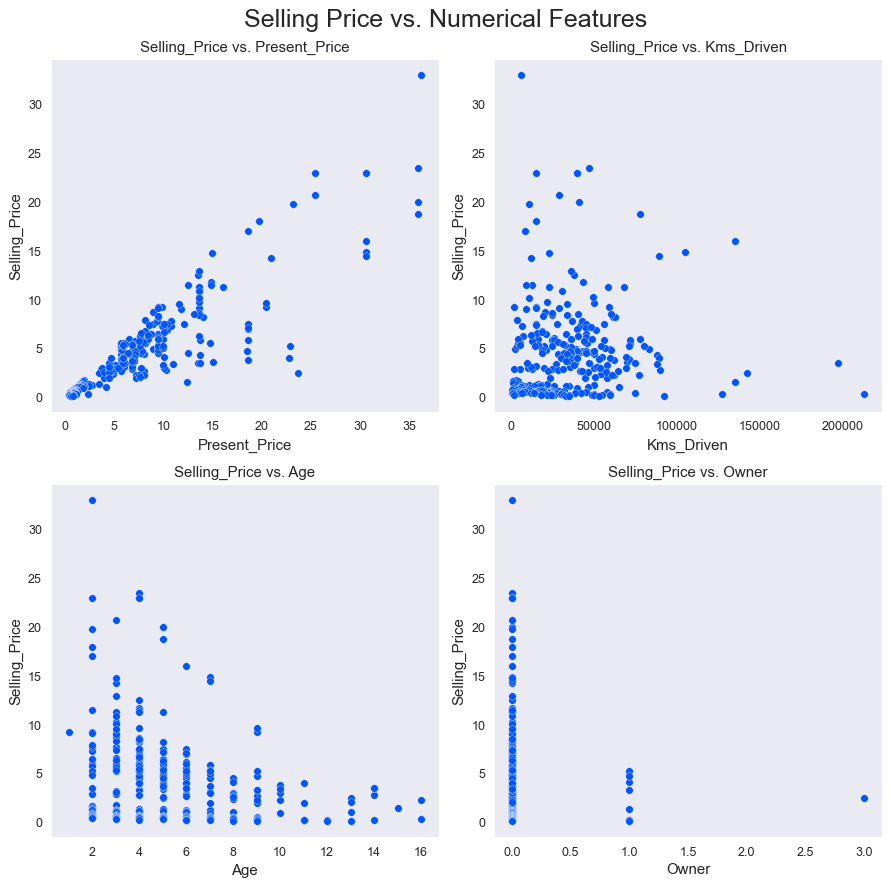

In [23]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10), dpi = 90)
num_features = ['Present_Price', 'Kms_Driven', 'Age', 'Owner']
target = 'Selling_Price'
c = '#0055ff'

for i in range(len(num_features)):
    row = i//2
    col = i%2
    ax[row,col].scatter(df1[num_features[i]], df1[target], color = c, edgecolor = 'w', linewidths = 0.25)
    ax[row,col].set_title('{} vs. {}'.format(target, num_features[i]), size = 12)
    ax[row,col].set_xlabel(num_features[i], size = 12)
    ax[row,col].set_ylabel(target, size = 12)
    ax[row,col].grid()
                          
plt.suptitle('Selling Price vs. Numerical Features', size =20)
plt.tight_layout()
plt.show()

# Selling Price Vs Categorical Features Bivariate Analysis.

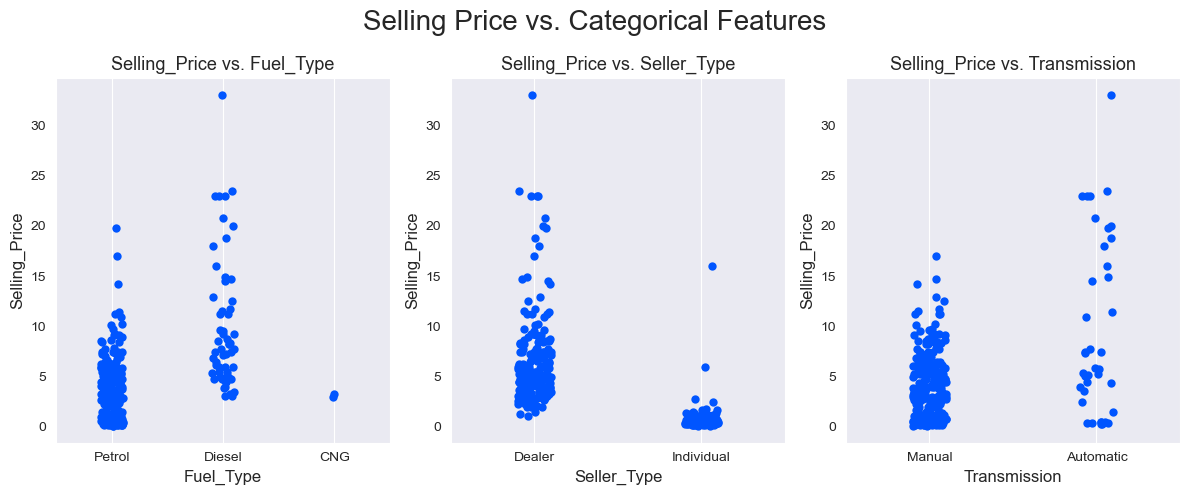

In [25]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(12,5), dpi = 100)
cat_features = ['Fuel_Type', 'Seller_Type', 'Transmission']
target = 'Selling_Price'
c = '#0055ff'

for i in range(len(cat_features)):
    sns.stripplot(ax = axes[i], x = cat_features[i], y = target, data = df1, size = 6, color = c)
    axes[i].set_title('{} vs. {}'.format(target, cat_features[i]), size = 13)
    axes[i].set_xlabel(cat_features[i], size = 12)
    axes[i].set_ylabel(target, size = 12)
    axes[i].grid()

plt.suptitle('Selling Price vs. Categorical Features', size = 20)
plt.tight_layout()
plt.show()                  

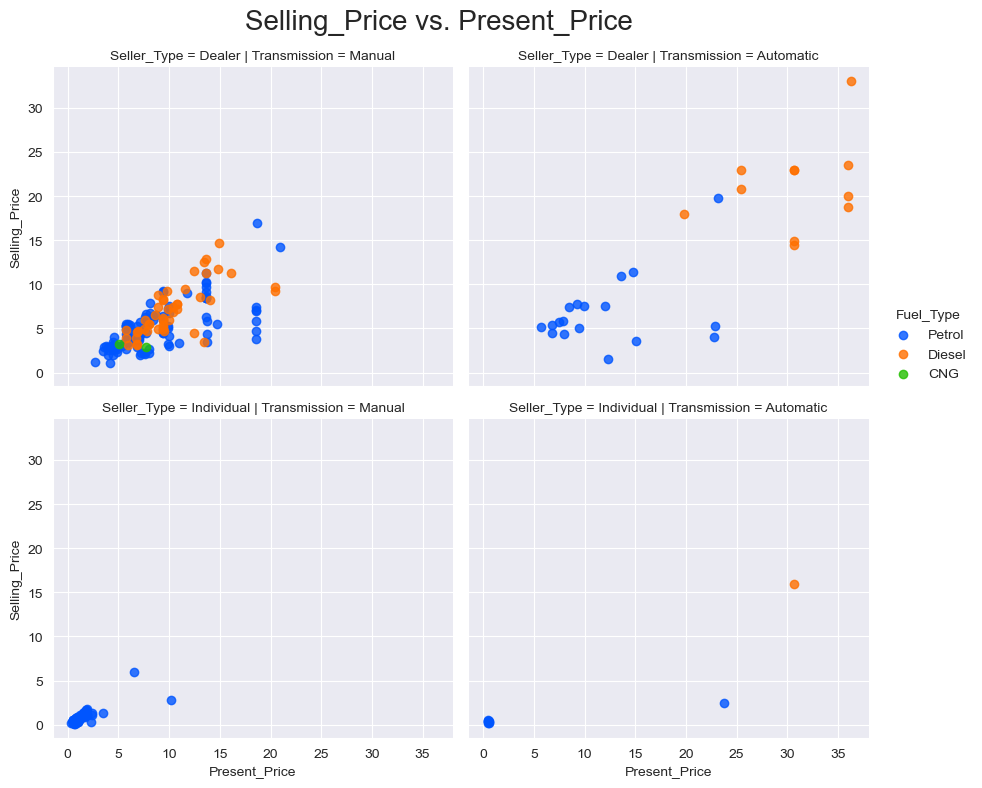

In [26]:
graph = sns.lmplot(x='Present_Price', y='Selling_Price', data=df1, fit_reg=False, row='Seller_Type', col='Transmission', hue='Fuel_Type', palette=CustomPalette, height=4, aspect=1)
plt.suptitle('Selling_Price vs. Present_Price', fontsize=20)
sns.move_legend(graph, "lower center", bbox_to_anchor=(1.05, 0.5), ncol=1)
plt.tight_layout()
plt.show()

# Categorical variables Encoding.

In [28]:
CatCols = ['Fuel_Type','Seller_Type','Transmission']
df1 = pd.get_dummies(df1, columns=CatCols, drop_first=True)
df1.head(5)

,Age,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,5,3.35,5.59,27000,0,False,True,False,True
1,6,4.75,9.54,43000,0,True,False,False,True
2,2,7.25,9.85,6900,0,False,True,False,True
3,8,2.85,4.15,5200,0,False,True,False,True
4,5,4.60,6.87,42450,0,True,False,False,True


# Correlation Analysis.

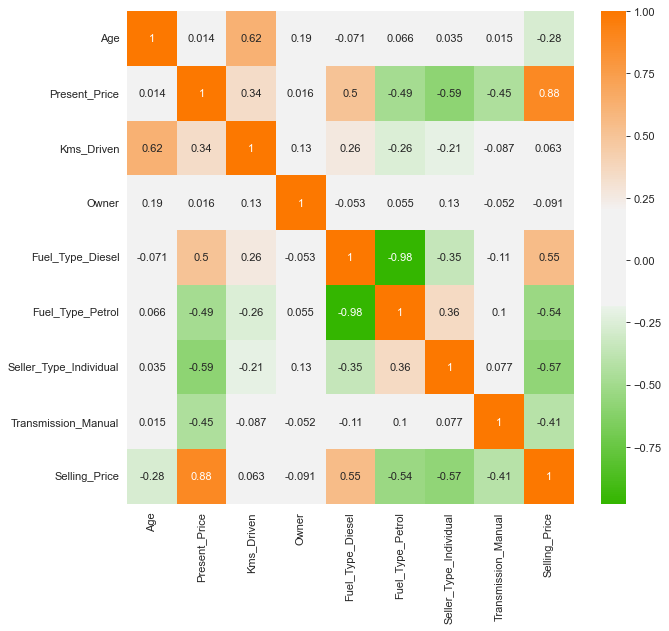

In [30]:
target = 'Selling_Price'
cmap = sns.diverging_palette(125, 28, s=100, l=65, sep=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(9, 8), dpi =80)
ax = sns.heatmap(pd.concat([df1.drop(target,axis=1), df1[target]],axis=1).corr(), annot =True, cmap=cmap)
plt.show()

# Bulid the Model.

In [32]:
X = df1.drop('Selling_Price', axis=1)
y = df1['Selling_Price']

In [33]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [34]:
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (239, 8)
x_test shape:  (60, 8)
y_train shape:  (239,)
y_test shape:  (60,)


In [35]:
y_test_actual = y_test

# Normalize the Dataset.

In [37]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [38]:
linear_reg = LinearRegression()
linear_reg.fit(x_train_scaled, y_train)

LinearRegression()

# Train the Model

In [40]:
# Create DataFrame for intercept and coefficients
coef_df = pd.DataFrame(data=np.append(linear_reg.intercept_, linear_reg.coef_),
                       index=['Intercept'] + [col + " Coef." for col in x_train.columns],
                       columns=['Value'])

# Sort the DataFrame by 'Value' in descending order
sorted_coef_df = coef_df.sort_values('Value', ascending=False)

print(sorted_coef_df)

                                 Value
Intercept                     4.323891
Present_Price Coef.           3.535901
Fuel_Type_Diesel Coef.        0.854292
Fuel_Type_Petrol Coef.        0.210351
Transmission_Manual Coef.     0.022801
Owner Coef.                  -0.203093
Seller_Type_Individual Coef. -0.338828
Kms_Driven Coef.             -0.561167
Age Coef.                    -0.875016


# Evaluation of the Model.

In [42]:
def model_evaluation(model, x_test, y_test, model_name):
    y_pred = model.predict(x_test)

    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score =  metrics.r2_score(y_test, y_pred)
    return pd.DataFrame([MAE, MSE, RMSE, R2_Score], index = ['MAE', 'MSE', 'RMSE', 'R2_Score'],columns = [model_name])
model_evaluation(linear_reg,x_test,y_test, 'Linear Reg.')

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


,Linear Reg.
MAE,1.783091e+04
MSE,4.400745e+08
RMSE,2.097795e+04
R2_Score,-1.154539e+07


In [43]:
# Initialize the model and the pipeline
linear_reg_cv = LinearRegression()
pipeline = make_pipeline(StandardScaler(), LinearRegression())

# Define the cross-validation strategy
kf = KFold(n_splits=6, shuffle=True, random_state=0)

# Define the scoring metrics
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']

# Perform cross-validation
result = cross_validate(pipeline, X, y, cv=kf, return_train_score=True, scoring=scoring)

# Calculate mean and standard deviation for each metric
MAE_mean = (-result['test_neg_mean_absolute_error']).mean()
MAE_std = (-result['test_neg_mean_absolute_error']).std()
MSE_mean = (-result['test_neg_mean_squared_error']).mean()
MSE_std = (-result['test_neg_mean_squared_error']).std()
RMSE_mean = (-result['test_neg_root_mean_squared_error']).mean()
RMSE_std = (-result['test_neg_root_mean_squared_error']).std()
R2_Score_mean = result['test_r2'].mean()
R2_Score_std = result['test_r2'].std()

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Mean': [MAE_mean, MSE_mean, RMSE_mean, R2_Score_mean],
    'std': [MAE_std, MSE_std, RMSE_std, R2_Score_std]
}, index=['MAE', 'MSE', 'RMSE', 'R2_Score'])

print(results_df)

              Mean       std
MAE       1.154774  0.147377
MSE       3.131755  1.314319
RMSE      1.728702  0.378609
R2_Score  0.855703  0.033720


# Results Visualization.

In [45]:
y_test_pred = linear_reg.predict(x_test_scaled)
df_comp = pd.DataFrame({'Actual':y_test_actual, 'Predicted':y_test_pred})

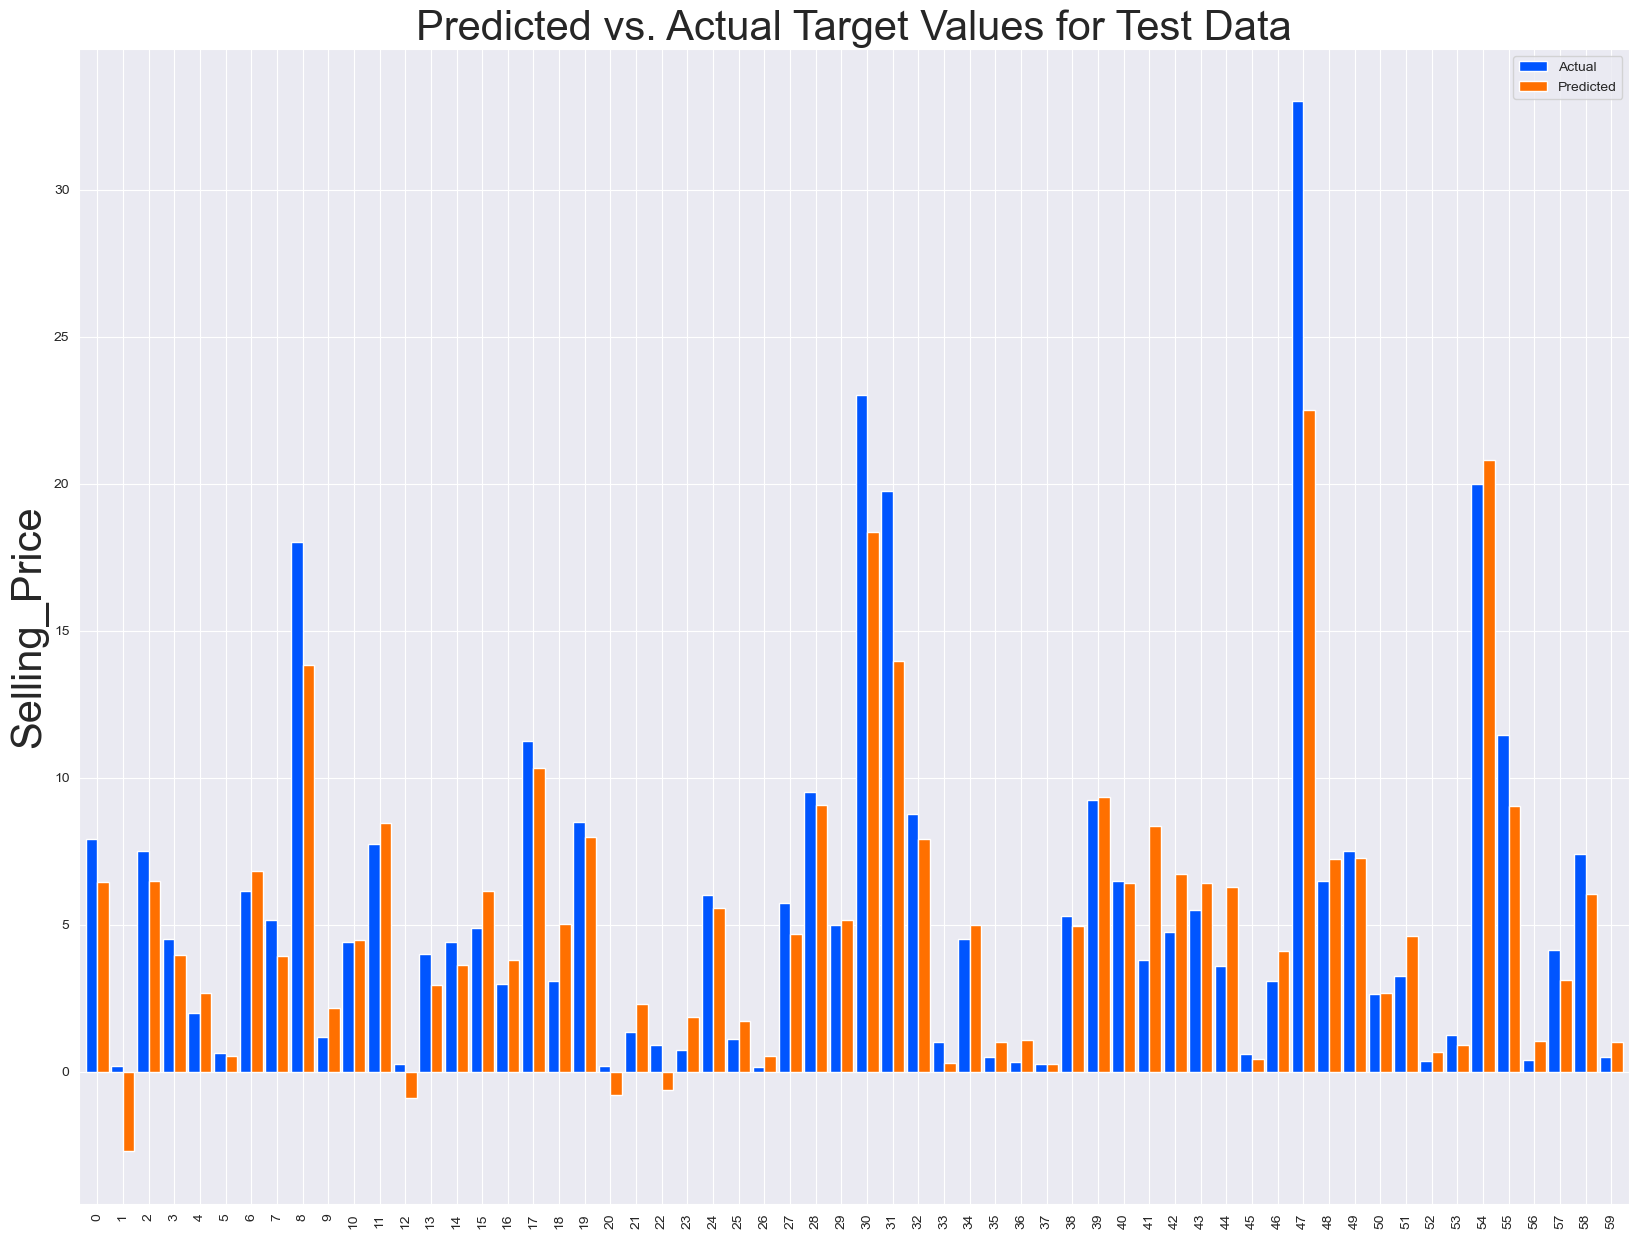

In [46]:
def compare_plot(df_comp):
    df_comp.reset_index(inplace = True)
    df_comp.plot(y=['Actual', 'Predicted'], kind = 'bar', figsize = (20, 15), width = 0.9)
    plt.title('Predicted vs. Actual Target Values for Test Data', fontsize = 30)
    plt.ylabel('Selling_Price', fontsize = 30)
    plt.show()

compare_plot(df_comp)